In [1]:
!pip install trustgraph-base
!pip install igraph

In [2]:
!pip install cairocffi

In [3]:
import igraph as ig
import trustgraph.api as tg
from trustgraph.api import Uri, Literal

In [4]:
cli = tg.Api()

In [5]:
# Utility function, given a label works backward to find the URI of the graph node associated with that label
def get_entity(label):

    resp = cli.triples_query(
        p = Uri("http://www.w3.org/2000/01/rdf-schema#label"),
        o = Literal(label),
        limit = 1
    )

    # Return first row answer
    for row in resp:
        return row.s

    # Or raise exception
    raise RuntimeError("Couldn't resolve entity")

In [6]:
# Given an entity URI, find the label
def get_label(ent):

    if ent == "http://www.w3.org/2000/01/rdf-schema#label": return "label"
    if ent == "https://schema.org/subjectOf": return "subject of"
    if ent.startswith("https://trustgraph.ai/doc/"): return "source document"
    if ent == "http://www.w3.org/2004/02/skos/core#definition": return "definition"
    if ent == "https://schema.org/keywords": return "keyword"
    if ent == "https://schema.org/description": return "keyword"
    if ent == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type": return "type"
    if ent == "https://schema.org/copyrightNotice": return "(c) notice"
    if ent == "https://schema.org/copyrightHolder": return "(c) held"
    if ent == "https://schema.org/copyrightYear": return "(c) year"

    if not ent.startswith("http"): return ent

    resp = cli.triples_query(
        s = ent,
        p = Uri("http://www.w3.org/2000/01/rdf-schema#label"),
        limit = 1
    )

    for row in resp:
        return row.o
        
    # If no label, just dump the entity, the URI can be its label
    return ent

In [7]:
# Given a graph node specified by URI, find related edges which start at that node
def get_related_edges(s, limit=20, follows=1):

    resp = cli.triples_query(
        s = s,
        limit = limit
    )

    res = [
        [s, row.p, row.o]
        for row in resp
    ]

    if follows > 1:
        seeds = [ r[2] for r in res ]
        for se in seeds:
            if se.startswith("http"):
                res.extend(get_related_edges(se, limit, follows - 1))

    return res

In [8]:
# Get some useful starting seeds
leaseholder = get_entity("leaseholder")
freeholder = get_entity("freehold")
resident = get_entity("resident")
lfra = get_entity("Leasehold and Freehold Reform Act 2024")

In [9]:
# Follow edges start at the seeds above to build a collection of statements
triples = []
triples.extend(get_related_edges(leaseholder, 10, 2))
triples.extend(get_related_edges(freeholder, 10, 2))
triples.extend(get_related_edges(resident, 10, 2))
triples.extend(get_related_edges(lfra, 10, 2))

In [10]:
len(triples)

99

## Visualization
Transform for graph vis

In [11]:
# Produces a list of entities which are sources and objects.  This list does not contain predicates
ents = list(set([t[0] for t in triples] + [t[2] for t in triples]))
vertex_labels = [ get_label(ent)[:25] for ent in ents]

In [12]:
# URI to ID mapping in both directions
id2uri = { ix: ent for ix, ent in enumerate(ents) }
uri2id = { ent: ix for ix, ent in enumerate(ents) }

# ID to human-readable label for nodes
id2name = { ix: name for ix, name in enumerate(vertex_labels) }

In [13]:
# Edge list, list of (subject, object) pairs
edges = [(uri2id[t[0]], uri2id[t[2]]) for t in triples]

In [14]:
# Mapping from edge to edge label
edge_labels = [ 
    get_label(t[1])[:20] for t in triples
]

In [15]:
g = ig.Graph(n=len(ents), edges=edges, directed=True)
g.vs["label"] = vertex_labels
g.vs["label_size"] = [10] * len(vertex_labels)
g.es["label"] = edge_labels
g.es["label_size"] = [10] * len(edge_labels)

In [16]:
print(g)

IGRAPH D--- 84 99 --
+ attr: label (v), label_size (v), label (e), label_size (e)
+ edges:
41->63 41->82 41->12 41->79 41->21 41->61 41->33 41->62 63->51 63->36 63->53
63->16 63->66 63->20 63->67 63->44 63->55 63->77 12->71 12->40 12->58 12->49
12->11 12->9 12->73 12->32 12->75 12->38 62->35 62->1 62->1 62->15 62->27
64->17 64->57 64->19 64->74 64->47 64->17 64->73 64->25 64->2 64->42 17->68
17->8 17->31 17->52 17->28 17->37 17->39 17->78 17->54 17->3 57->46 57->62
19->56 19->83 19->0 19->23 19->62 17->68 17->8 17->31 17->52 17->28 17->37
17->39 17->78 17->54 17->3 70->22 70->10 70->30 70->29 29->35 29->5 29->5
29->14 29->6 24->59 24->27 24->81 24->1 24->34 24->65 24->45 24->43 24->76
24->60 81->13 81->26 81->7 81->4 81->50 81->18 81->48 81->80 81->72 81->69


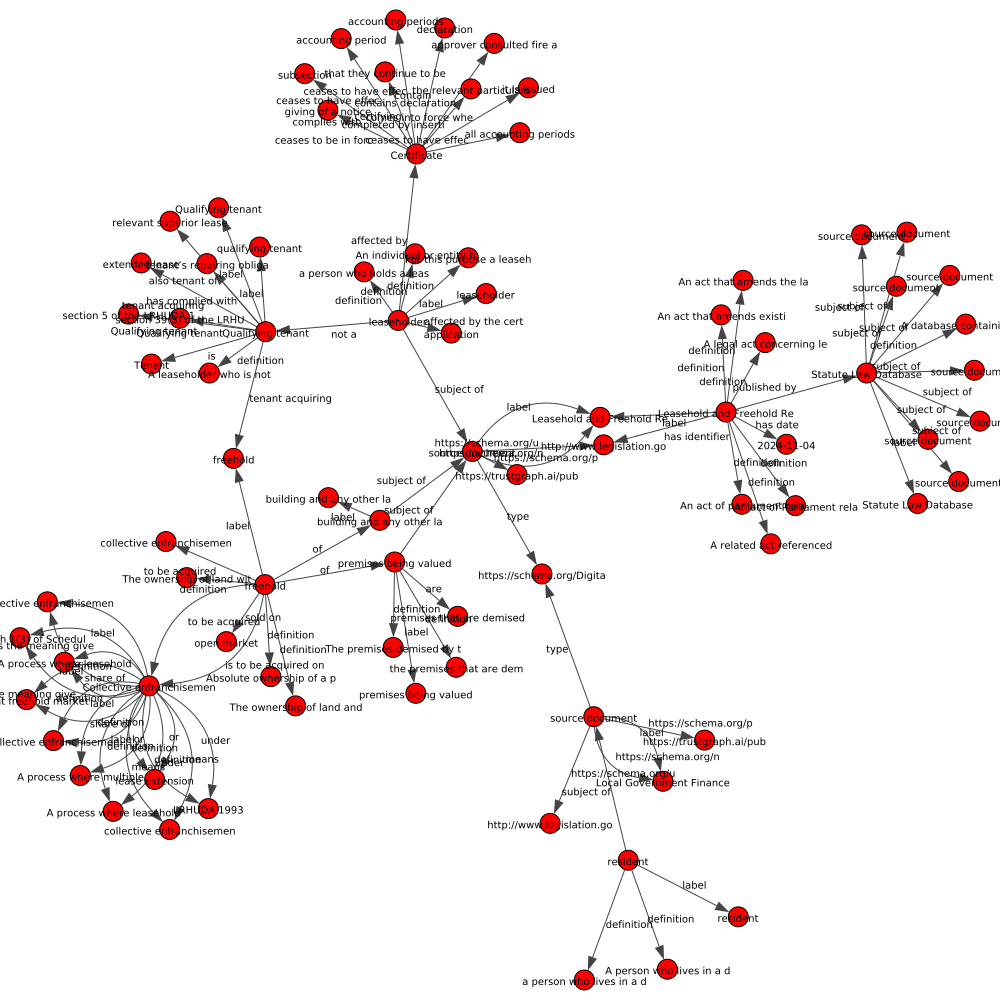

In [17]:
layout = g.layout("kk")

ig.plot(g, layout=layout, bbox=(0, 0, 1000, 1000))